<a href="https://colab.research.google.com/github/farhansyed13/internshipproject/blob/main/PRCP1006HomeLoanDef.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Shape: (307511, 122)
TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64


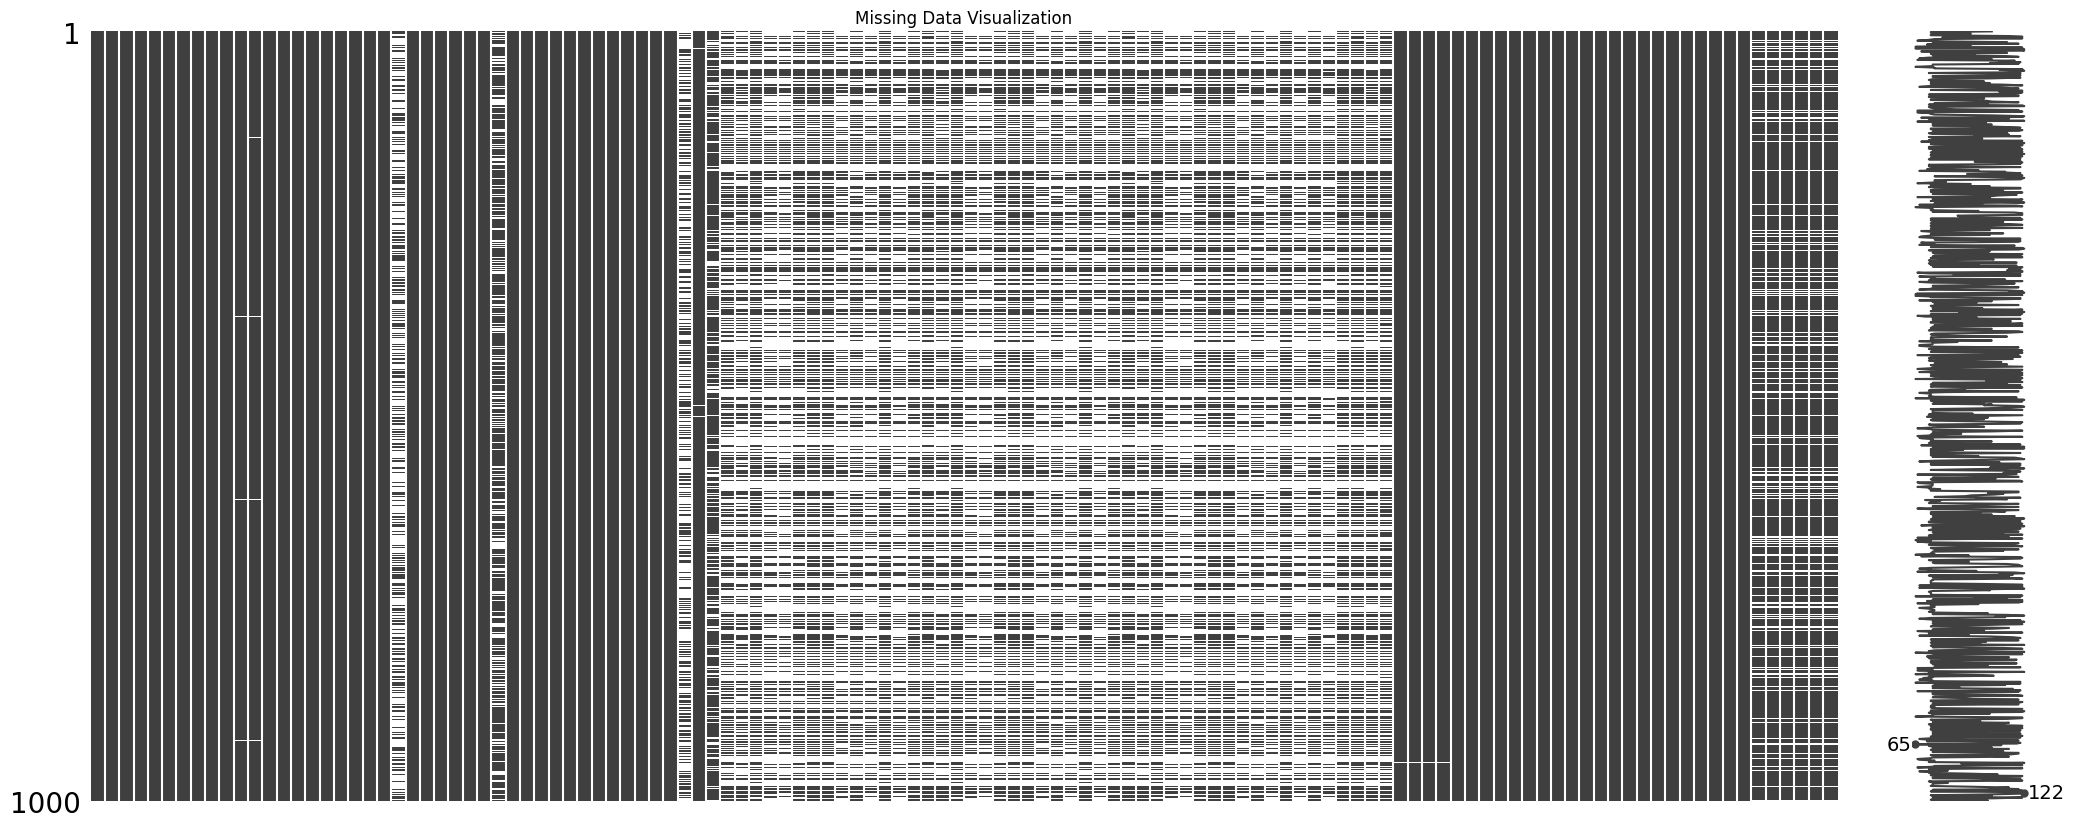

Top Correlated Features:
 TARGET                         1.000000
DAYS_BIRTH                     0.078239
REGION_RATING_CLIENT_W_CITY    0.060893
REGION_RATING_CLIENT           0.058899
DAYS_LAST_PHONE_CHANGE         0.055218
DAYS_ID_PUBLISH                0.051457
REG_CITY_NOT_WORK_CITY         0.050994
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_DOCUMENT_3                0.044346
Name: TARGET, dtype: float64
Categorical Features: ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']
--- Logistic Regression ---
Accuracy: 0.9194023055785897
Confusion Matrix:
 [[56482    72]
 [ 4885    64]]
Classification Report:
               precision    recall  f1-score   support

    

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:47:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


--- XGBoost ---
Accuracy: 0.9195323805342829
Confusion Matrix:
 [[56383   171]
 [ 4778   171]]
Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     56554
           1       0.50      0.03      0.06      4949

    accuracy                           0.92     61503
   macro avg       0.71      0.52      0.51     61503
weighted avg       0.89      0.92      0.89     61503



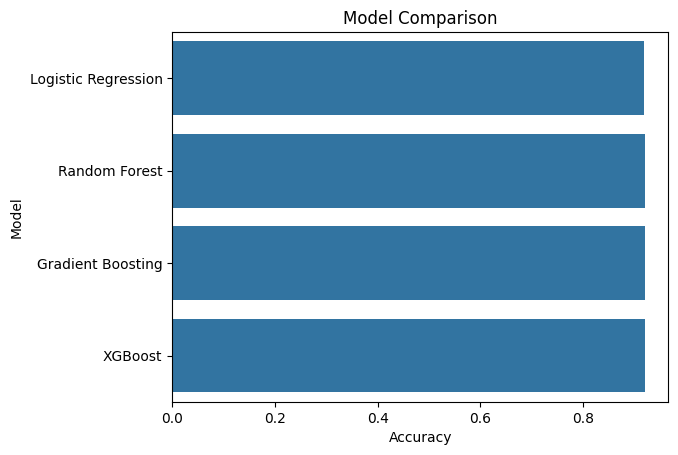

In [ ]:
# === Setup & Imports ===
!pip install missingno --quiet

import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
import missingno as msno
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
import zipfile
import urllib.request
import os

# === Download and unzip dataset ===
url = "https://d3ilbtxij3aepc.cloudfront.net/projects/CDS-Capstone-Projects/PRCP-1006-HomeLoanDef.zip"
zip_path = "home_loan_data.zip"
if not os.path.exists(zip_path):
    urllib.request.urlretrieve(url, zip_path)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("home_loan_data")

# === Load main dataset ===
app_train = pd.read_csv("/content/drive/MyDrive/application_train.csv") # Changed to the extracted path
print("Shape:", app_train.shape)
print(app_train['TARGET'].value_counts(normalize=True))

# === EDA ===
msno.matrix(app_train.sample(1000))
plt.pyplot.title("Missing Data Visualization") # Changed to plt.pyplot
plt.pyplot.show()

# Visualize correlation with target
# Convert all object type to numeric for correlation analysis
numeric_app_train = app_train.apply(pd.to_numeric, errors='coerce') # Convert to numeric, errors to NaN
corr = numeric_app_train.corr()['TARGET'].sort_values(ascending=False)
print("Top Correlated Features:\n", corr.head(10))


# Categorical variables overview
categorical = app_train.select_dtypes(include=['object']).columns.tolist()
print("Categorical Features:", categorical)

# Label encoding for binary categoricals
le = LabelEncoder()
for col in categorical:
    if app_train[col].nunique() == 2:
        app_train[col] = le.fit_transform(app_train[col].astype(str))

# One-hot encoding for other categoricals
app_train = pd.get_dummies(app_train, drop_first=True)

# Handle missing values (remove features with >40% missing)
missing = app_train.isnull().mean()
drop_cols = missing[missing > 0.4].index.tolist()
app_train.drop(columns=drop_cols, inplace=True)
app_train.fillna(app_train.median(), inplace=True)

# === Prepare Data for Modeling ===
X = app_train.drop(columns=['TARGET', 'SK_ID_CURR'])
y = app_train['TARGET']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# === Model Training & Evaluation ===
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    results[name] = score
    print(f"--- {name} ---")
    print("Accuracy:", score)
    print("Confusion Matrix:\n", confusion_matrix(y_test, model.predict(X_test)))
    print("Classification Report:\n", classification_report(y_test, model.predict(X_test)))

# === Model Comparison ===
result_df = pd.DataFrame(results.items(), columns=["Model", "Accuracy"])
sns.barplot(data=result_df, x="Accuracy", y="Model")
plt.pyplot.title("Model Comparison") # Changed to plt.pyplot
plt.pyplot.show()